In [162]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [163]:
os.getcwd()
os.chdir(os.getcwd())


Read 4 json files and transform them into DataFrames, then concat into 1 final DataFrame (df)

In [164]:
df_part_1 = pd.read_json("Spotify Extended Streaming History/Streaming_History_Audio_2020-2023_0.json")
df_part_2 = pd.read_json("Spotify Extended Streaming History/Streaming_History_Audio_2023_1.json")
df_part_3 = pd.read_json("Spotify Extended Streaming History/Streaming_History_Audio_2023-2024_2.json")
# df_part_4 = pd.read_json("Spotify Extended Streaming History\Streaming_History_Video_2020-2024.json")

In [165]:
# Concat all given DataFrames into 1 DF for further analyses
spotify_df = pd.concat([df_part_1, df_part_2, df_part_3])
# Removing username column because I am the only one using this account
spotify_df.drop(columns=['username'], inplace=True)

In [166]:
spotify_df.head()

,ts,platform,ms_played,conn_country,ip_addr_decrypted,user_agent_decrypted,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
0,2020-08-22T16:34:56Z,Windows 10 (10.0.18363; x64; AppX),238360,VN,171.241.150.149,unknown,unravel,TK from Ling tosite sigure,Fantastic Magic,spotify:track:0GLyqTysS0DFoeKjURtB8s,None,None,None,clickrow,trackdone,False,NaN,False,1598113859206,False
1,2020-08-22T16:40:32Z,Windows 10 (10.0.18363; x64; AppX),9490,VN,171.241.150.149,unknown,katharsis,TK from Ling tosite sigure,Katharsis,spotify:track:0PnrdoLqdpScsUTYd06Zb8,None,None,None,trackdone,logout,False,NaN,False,1598114096805,False
2,2020-08-22T16:40:42Z,Windows 10 (10.0.18363; x64; AppX),2500,VN,171.241.150.149,unknown,Dancing With A Stranger (with Normani),Sam Smith,Dancing With A Stranger (with Normani),spotify:track:6Qs4SXO9dwPj5GKvVOv8Ki,None,None,None,clickrow,endplay,False,NaN,False,1598114439494,False
3,2020-08-22T16:40:45Z,Windows 10 (10.0.18363; x64; AppX),3100,VN,171.241.150.149,unknown,How Do You Sleep?,Sam Smith,How Do You Sleep?,spotify:track:6b2RcmUt1g9N9mQ3CbjX2Y,None,None,None,clickrow,endplay,False,NaN,False,1598114442297,False
4,2020-08-22T16:40:52Z,Windows 10 (10.0.18363; x64; AppX),6580,VN,171.241.150.149,unknown,Too Good At Goodbyes,Sam Smith,The Thrill Of It All,spotify:track:1mXVgsBdtIVeCLJnSnmtdV,None,None,None,clickrow,endplay,False,NaN,False,1598114445537,False


In [167]:
music_df = spotify_df.drop(columns=['episode_name', 'episode_show_name', 'spotify_episode_uri'],inplace=False)
# Using the Music DF to only concern about music listened during my usage of Spotify from 2020 upto now

### Descriptive statistics of listening habit

In [168]:
print("Total tracks listened:", len(music_df))
print("Number of artists listened to:", music_df['master_metadata_album_artist_name'].nunique())
print("Number of unique songs listened to:", music_df['master_metadata_track_name'].nunique())

Total tracks listened: 41162
Number of artists listened to: 2876
Number of unique songs listened to: 7531


In [169]:
top_10_artist = music_df['master_metadata_album_artist_name'].value_counts().head(10)
print("Top 10 artists of choice:", top_10_artist)

Top 10 artists of choice: master_metadata_album_artist_name
Metro Boomin            985
Post Malone             929
The Weeknd              918
Arctic Monkeys          917
RPT MCK                 671
Aries                   634
Lý Bực                  631
Taylor Swift            623
Bring Me The Horizon    569
Linkin Park             509
Name: count, dtype: int64


Clean the data before conducting graphs

In [170]:
# top_10 = music_df[music_df['master_metadata_album_artist_name'].isin(top_10_artist.index)]
music_df['datetime'] = pd.to_datetime(music_df['ts'])
music_df['hours_played'] = music_df['ms_played']/(3_600_000)
music_df.drop(labels=['ts','ms_played', 'conn_country'],axis=1, inplace=True)
music_df.head(10)

,platform,ip_addr_decrypted,user_agent_decrypted,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode,datetime,hours_played
0,Windows 10 (10.0.18363; x64; AppX),171.241.150.149,unknown,unravel,TK from Ling tosite sigure,Fantastic Magic,spotify:track:0GLyqTysS0DFoeKjURtB8s,clickrow,trackdone,False,NaN,False,1598113859206,False,2020-08-22 16:34:56+00:00,0.066211
1,Windows 10 (10.0.18363; x64; AppX),171.241.150.149,unknown,katharsis,TK from Ling tosite sigure,Katharsis,spotify:track:0PnrdoLqdpScsUTYd06Zb8,trackdone,logout,False,NaN,False,1598114096805,False,2020-08-22 16:40:32+00:00,0.002636
2,Windows 10 (10.0.18363; x64; AppX),171.241.150.149,unknown,Dancing With A Stranger (with Normani),Sam Smith,Dancing With A Stranger (with Normani),spotify:track:6Qs4SXO9dwPj5GKvVOv8Ki,clickrow,endplay,False,NaN,False,1598114439494,False,2020-08-22 16:40:42+00:00,0.000694
3,Windows 10 (10.0.18363; x64; AppX),171.241.150.149,unknown,How Do You Sleep?,Sam Smith,How Do You Sleep?,spotify:track:6b2RcmUt1g9N9mQ3CbjX2Y,clickrow,endplay,False,NaN,False,1598114442297,False,2020-08-22 16:40:45+00:00,0.000861
4,Windows 10 (10.0.18363; x64; AppX),171.241.150.149,unknown,Too Good At Goodbyes,Sam Smith,The Thrill Of It All,spotify:track:1mXVgsBdtIVeCLJnSnmtdV,clickrow,endplay,False,NaN,False,1598114445537,False,2020-08-22 16:40:52+00:00,0.001828
5,Windows 10 (10.0.18363; x64; AppX),171.241.150.149,unknown,My Oasis (feat. Burna Boy),Sam Smith,My Oasis (feat. Burna Boy),spotify:track:2KoHxhRyWxJzA0VafWd5Nk,clickrow,endplay,False,NaN,False,1598114452246,False,2020-08-22 16:40:55+00:00,0.000914
6,Windows 10 (10.0.18363; x64; AppX),171.241.150.149,unknown,To Die For,Sam Smith,To Die For,spotify:track:2ZTYlnhhV1UAReg7wIGolx,clickrow,endplay,False,NaN,False,1598114455667,False,2020-08-22 16:41:03+00:00,0.002233
7,Windows 10 (10.0.18363; x64; AppX),171.241.150.149,unknown,Promises (with Sam Smith),Calvin Harris,Promises (with Sam Smith),spotify:track:5N5k9nd479b1xpDZ4usjrg,clickrow,remote,False,NaN,False,1598114463842,False,2020-08-22 16:41:51+00:00,0.008056
8,"Android OS 10 API 29 (vsmart, Live)",103.19.99.55,unknown,Promises (with Sam Smith),Calvin Harris,Promises (with Sam Smith),spotify:track:5N5k9nd479b1xpDZ4usjrg,remote,trackdone,False,NaN,False,1598114491791,False,2020-08-22 16:44:55+00:00,0.051264
9,"Android OS 10 API 29 (vsmart, Live)",103.19.99.55,unknown,"Baby, You Make Me Crazy - Friction Remix",Sam Smith,"Baby, You Make Me Crazy",spotify:track:1vXp6ifT8y7gyMmWLREasX,trackdone,endplay,False,NaN,False,1598114688994,False,2020-08-22 16:45:47+00:00,0.015602


Text(0.5, 1.0, 'Top 10 artists by listening time')

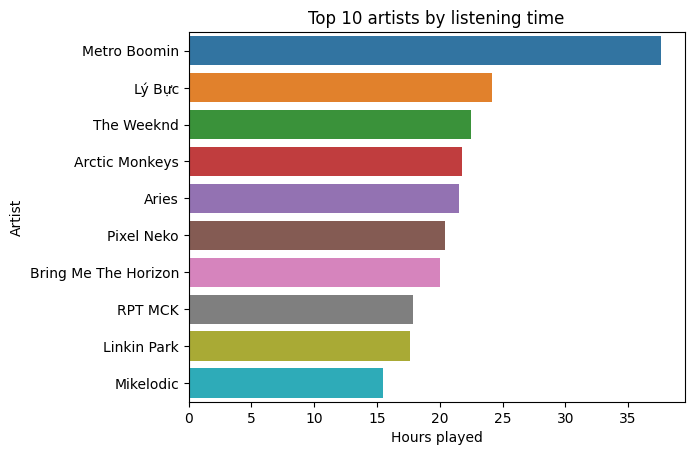

In [203]:
music_df_2023 = music_df[music_df['datetime'].apply(lambda t:t.year == 2023)]
music_df_2023 = music_df_2023.groupby('master_metadata_album_artist_name')['hours_played'].sum()
music_df_2023 = music_df_2023.sort_values(ascending=False).head(10)
music_df_2023 = music_df_2023.reset_index()
music_df_2023

sns.barplot(
    data=music_df_2023,
    x=music_df_2023.hours_played,
    y=music_df_2023.master_metadata_album_artist_name,
    orient='h'
)
plt.xlabel('Hours played')
plt.ylabel('Artist')
plt.title('Top 10 artists by listening time')



In [198]:
music_df_2023.values

array([['Metro Boomin', 37.618431944444445],
       ['Lý Bực', 24.190625833333332],
       ['The Weeknd', 22.49332888888889],
       ['Arctic Monkeys', 21.756473055555556],
       ['Aries', 21.55076222222222],
       ['Pixel Neko', 20.39299388888889],
       ['Bring Me The Horizon', 20.045768055555556],
       ['RPT MCK', 17.855542222222223],
       ['Linkin Park', 17.605621666666668],
       ['Mikelodic', 15.48717138888889]], dtype=object)